In [232]:
import cv2
import IPython
import matplotlib
import matplotlib.pyplot as pyplot
import keras
import keras.utils
import tensorflow as tf
import numpy as np

dataDir = "E:/Work/NonoGram/"

# https://cloudvision.app/image.html?rid=-M94KlEHAR6uSimUr61M


# Read image

In [233]:
#image = cv2.imread('E:/Work/NonoGram/Data/sample.png') 
#image = cv2.imread('E:/Work/NonoGram/Data/puzzle.jpg') 
image = cv2.imread('E:/Work/NonoGram/Data/wikipedia.png') 


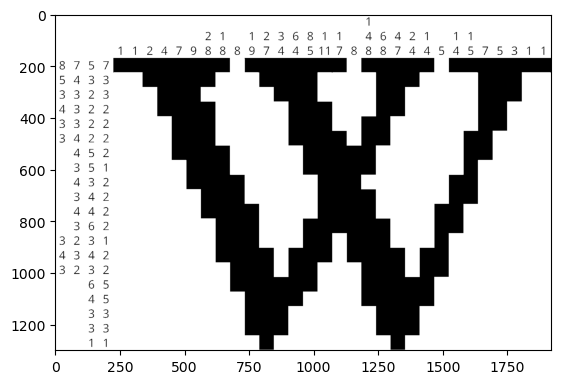

In [234]:
imageCopy = image.copy()
imageCopy = cv2.cvtColor(imageCopy, cv2.COLOR_BGR2GRAY)
imageCopy = cv2.GaussianBlur(imageCopy, (1, 1), 0)
(_, imageCopy) = cv2.threshold(imageCopy, 10, 255, cv2.THRESH_BINARY)
#imageCopy = cv2.cvtColor(imageCopy, cv2.COLOR_BGR2GRAY)
#blurred = cv2.GaussianBlur(gray, (5, 5), 0)
#imageCopy = cv2.Canny(imageCopy, 50, 150)
#imageCopy = 255-imageCopy
#imageCopy = cv2.Canny(imageCopy, 50, 150)
pyplot.imshow(imageCopy, cmap="gray")

# Find left and right based on lines

18890.5
[[[ 18  56]]

 [[ 18 158]]

 [[162 158]]

 [[162  15]]

 [[ 60  15]]

 [[ 59  56]]]
18873.5
[[[ 60  15]]

 [[ 60  55]]

 [[ 59  56]]

 [[ 18  56]]

 [[ 18 158]]

 [[162 158]]

 [[162  58]]

 [[163  57]]

 [[163  55]]

 [[162  54]]

 [[162  15]]]


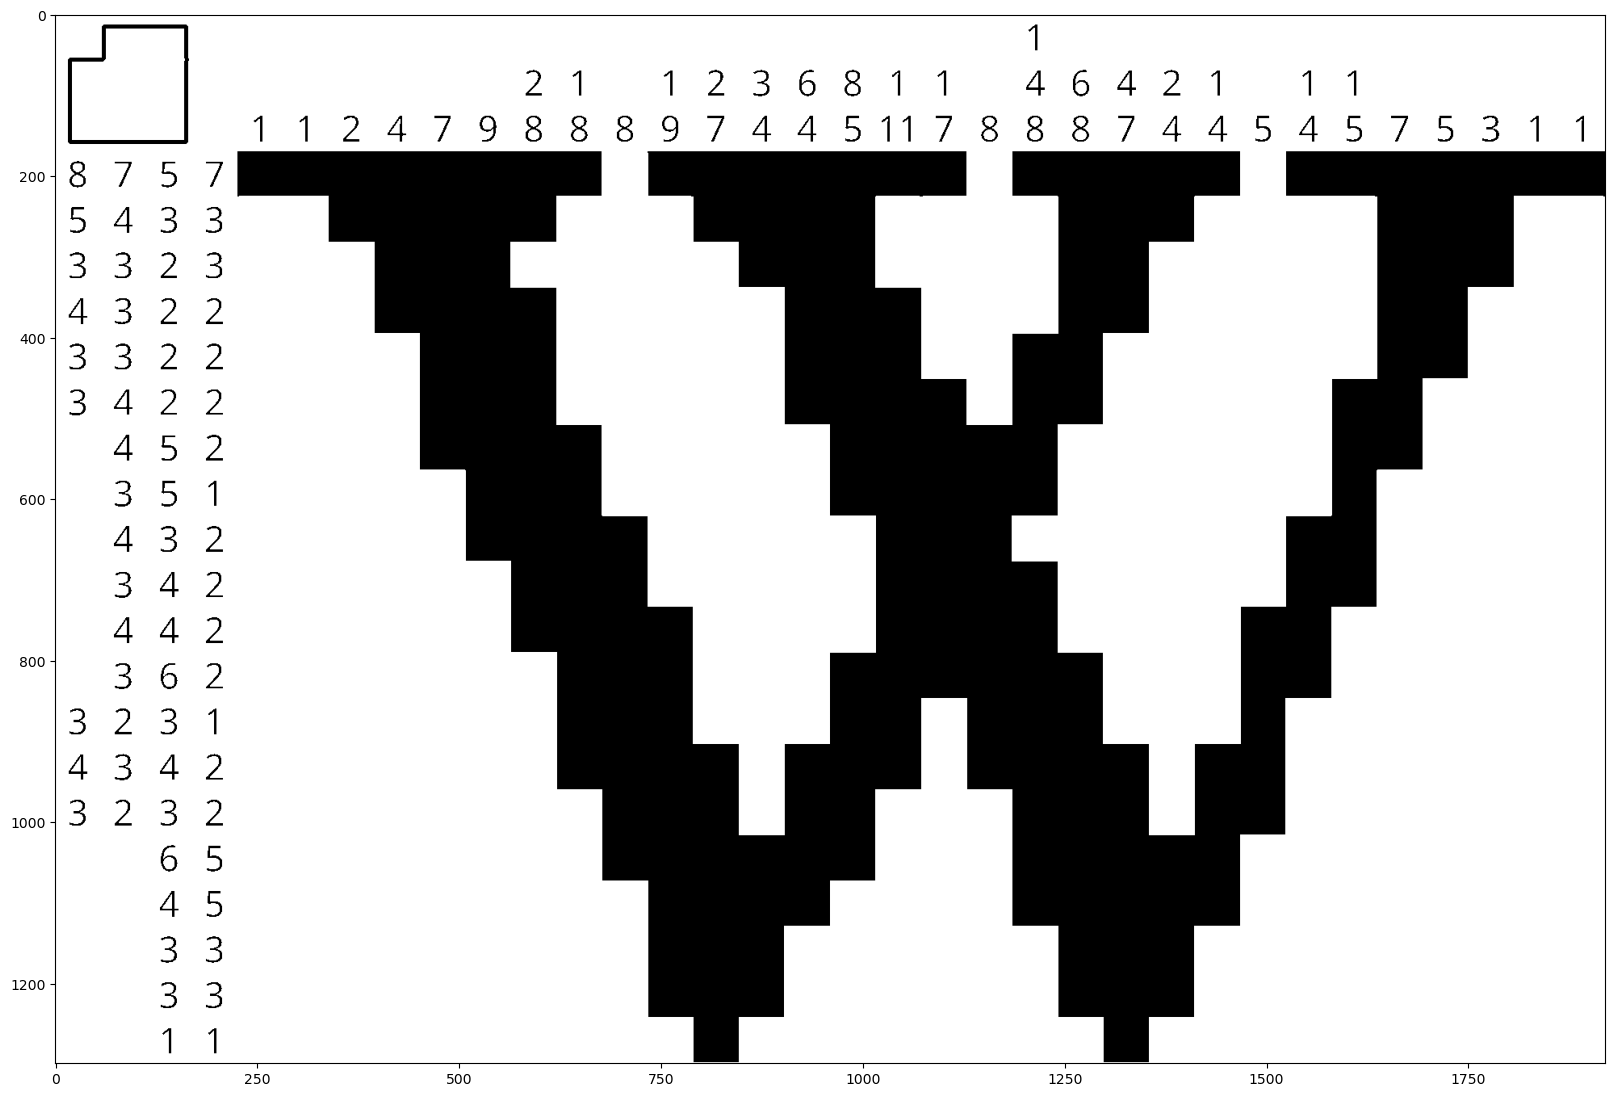

In [235]:
newContours = []
for contour in contours:
    if len(contour) > 0:
        epsilon = 0.01 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        print(cv2.contourArea(approx))
        print(approx)        
        print(cv2.contourArea(contour))
        print(contour)
        newContours.append(approx)
imageContours = imageCopy.copy()
cv2.drawContours(imageContours, contours, -1, (0, 255, 0), 3)        
pyplot.figure(figsize= (20,20))
pyplot.imshow(imageContours, cmap="gray")
pyplot.show()


In [236]:
outline = newContours[0]

[59 56]


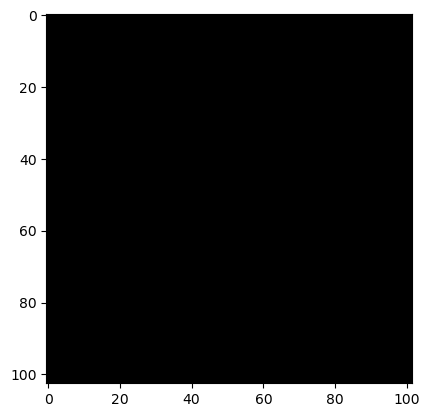

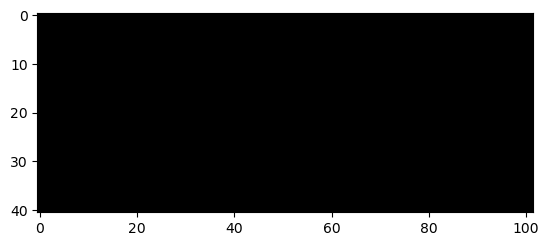

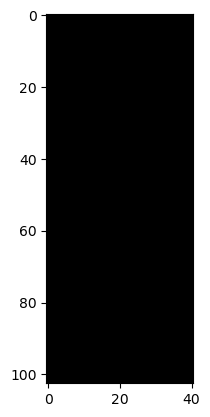

In [237]:
topLeft = (outline.min(axis=0, keepdims=True))[0][0]
bottomRight = outline.max(axis=0, keepdims=True)[0][0]
for pointArray in outline:
    point = pointArray[0]
    if (
            point[0] > topLeft[0] and point[0] < bottomRight[0] and
            point[1] > topLeft[1] and point[1] < bottomRight[1]
        ):
        insidePoint = point
print(insidePoint)
insideImage = imageCopy[insidePoint[0]:bottomRight[0], insidePoint[1]:bottomRight[1]]
topSide = imageCopy[topLeft[0]:insidePoint[0], insidePoint[1]:bottomRight[1]]
leftSide = imageCopy[insidePoint[0]:bottomRight[0], topLeft[1]:insidePoint[1]]

pyplot.imshow(insideImage, cmap="gray")
pyplot.show()
pyplot.imshow(topSide, cmap="gray")
pyplot.show()
pyplot.imshow(leftSide, cmap="gray")
pyplot.show()

# todo check and test :D


# Train model

In [238]:
from keras.models import load_model
# Load the MNIST dataset from OpenCV (this loads pre-trained data)
# This is a convenient way to quickly get started with digit recognition.
def createDigitRecognizer():
    # Load the MNIST dataset
    (train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
    
    # Preprocess the images
    train_images = train_images.astype('float32') / 255
    test_images = test_images.astype('float32') / 255

    # Reshape the images and add a channel dimension
    train_images = np.expand_dims(train_images, axis=-1)
    test_images = np.expand_dims(test_images, axis=-1)

    # One-hot encode the labels
    train_labels = tf.keras.utils.to_categorical(train_labels)
    test_labels = tf.keras.utils.to_categorical(test_labels)
    
    # Build the CNN model
    model = keras.Sequential([
        keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(10, activation='softmax')
    ])
    
    # Compile the model
    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    # Train the model
    model.fit(train_images, train_labels, epochs=5, batch_size=64, validation_data=(test_images, test_labels))
    return model

import os

import keras.saving
digitRecognizerModelFileName = f"{dataDir}/digitRecognizerMnist.keras"
if (os.path.exists(digitRecognizerModelFileName)):
    digitRecognizer = load_model(digitRecognizerModelFileName)
else:
    digitRecognizer = createDigitRecognizer()
    digitRecognizer.save(f"{dataDir}/digitRecognizerMnist.keras")

# Recognize digits

no digit found: 4 (226, 170, 1694, 1128) 1.50177304964539 [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


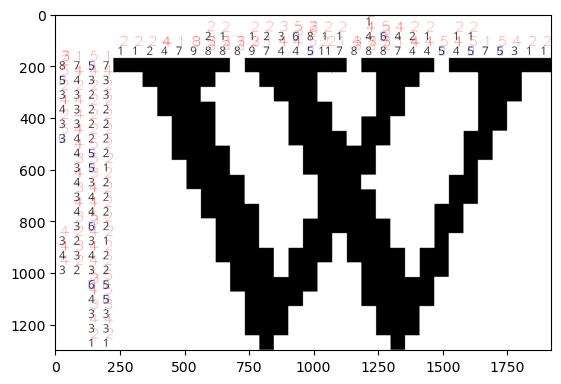

In [239]:
# Define a function to process the image and recognize digits
def recognize_digits(image):
    foundDigits = []
    imageCopy = image.copy()
    imageOutput = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    
    # Preprocess the image (resize, grayscale, thresholding, etc.)
    #gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(imageCopy, 150, 255, cv2.THRESH_BINARY_INV)

    # Find contours of the digit in the image
    contours, _ = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    #cv2.drawContours(imageOutput, contours, -1, (0, 0, 255), 1)

    for contour in contours:
        # Get bounding box around the contour (digit)
        x, y, w, h = cv2.boundingRect(contour)
        digit_image = thresh[y:y+h, x:x+w]

        # Resize the digit image to match the trained model size (28x28 for MNIST)
        digit_image_resized = cv2.resize(digit_image, (28, 28), interpolation=cv2.INTER_AREA)
        digit_image_resized = digit_image_resized.reshape(1, 28, 28, 1)
        #digit_image_resized = tf.expand_dims(digit_image_resized, axis=-1)

        # Use KNN to predict the digit
        #_, result, _, _ = digitRecognizer.predict(digit_image_resized)
        result = digitRecognizer(digit_image_resized)

        # Get the predicted digit       
        predictedIndex = np.argmax(result)
        #extractor = keras.Model(inputs=digitRecognizer.inputs, outputs=[layer.output for layer in digitRecognizer.layers])
        intermediate_layer_model = keras.Model(inputs=digitRecognizer.input,
                                       outputs=digitRecognizer.get_layer("dense_3").output)
        intermediate_output = intermediate_layer_model(digit_image_resized)
        #print(intermediate_output)

        predictedProbability = result[0][predictedIndex]
        x,y,width,height = cv2.boundingRect(contour); 
        aspectRatio = width / height
        area = cv2.contourArea(contour)
        #if (cv2.contourArea(contour) > 11450):
        #    cv2.drawContours(imageCopy, [contour], -1, (200, 200, 200), 3)

        if (predictedProbability > .8 and aspectRatio > .15 and aspectRatio < 1.5):# and area < 200):  # magic numbers!
            font = cv2.FONT_HERSHEY_PLAIN
            #cv2.putText(imageCopy, str(predictedIndex), (boundingBox[2], boundingBox[3]), font, .5, (100, 100, 100))
            cv2.putText(imageOutput, str(predictedIndex), (x, y), font, 4, (255, 0, 0))
            foundDigits.append(((x, y, width, height), predictedIndex))

            if (predictedIndex == 5):
                (x, y, w, h) = cv2.boundingRect(contour)
                cv2.rectangle(imageOutput, (x, y), (x+w,y+h), (0,0,255))

            #print(f"Predicted digit: {predictedIndex} {x,y,width,height} {aspectRatio} {result}")
        else:
            print(f"no digit found: {predictedIndex} {x,y,width,height} {aspectRatio} {result}")
        #print(f"Predicted digit: {predicted_digit} {contour}")
        #return predicted_digit
    pyplot.imshow(imageOutput, cmap="gray")
    return foundDigits

# Load an image of a handwritten digit (replace with your own image)
#image = cv2.imread('digit_image.png')  # Replace with the actual image path
#recognized_digit = 
foundDigits = recognize_digits(imageCopy)

remove (132, 1089, 14, 20) 1
remove (133, 1043, 16, 17) 3
remove (132, 919, 14, 20) 1
remove (19, 919, 14, 20) 1
remove (133, 817, 16, 17) 3
remove (132, 750, 14, 20) 1
remove (75, 750, 15, 20) 1
remove (132, 693, 14, 20) 1
remove (75, 637, 15, 20) 1
remove (75, 524, 15, 20) 1
remove (75, 467, 15, 21) 1
remove (19, 354, 14, 21) 1
remove (75, 242, 15, 20) 1
remove (20, 198, 16, 15) 2
remove (21, 184, 14, 13) 3
remove (1262, 142, 17, 15) 2
remove (1206, 142, 16, 15) 3
remove (1149, 142, 17, 15) 3
remove (698, 142, 16, 15) 3
remove (641, 142, 17, 15) 3
remove (585, 142, 16, 15) 3
remove (1544, 129, 14, 20) 1
remove (1431, 129, 14, 20) 1
remove (1374, 129, 15, 20) 4
remove (922, 129, 15, 20) 1
remove (866, 129, 14, 20) 1
remove (414, 129, 15, 20) 4
remove (1263, 127, 15, 14) 3
remove (1207, 127, 14, 14) 3
remove (1150, 127, 15, 14) 3
remove (754, 127, 16, 17) 3
remove (699, 127, 14, 14) 3
remove (642, 127, 15, 14) 3
remove (586, 127, 14, 14) 3
remove (528, 127, 16, 17) 3
remove (980, 85, 1

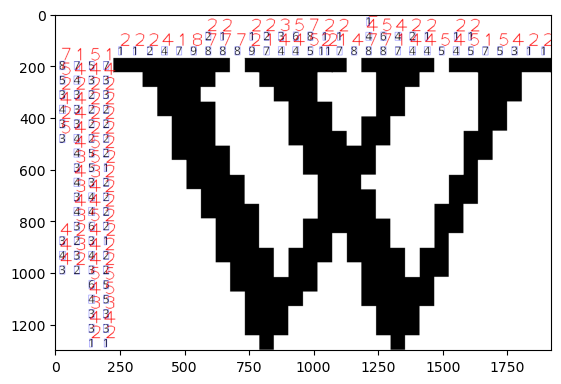

In [240]:
def removeOverlappingDigits(foundDigits):
    result = []

    for (boundingRect, digit) in foundDigits:
        hasOverlap = False
        for (otherBoundingRect, _) in foundDigits:
            overlapRect = (
                max(boundingRect[0], otherBoundingRect[0]), 
                max(boundingRect[1], otherBoundingRect[1]),
                min(boundingRect[0] + boundingRect[2], otherBoundingRect[0] + otherBoundingRect[2]), 
                min(boundingRect[1] + boundingRect[3], otherBoundingRect[1] + otherBoundingRect[3])
            )
            w = overlapRect[2] - overlapRect[0]
            h = overlapRect[3] - overlapRect[1]
            if (w > 0 and h > 0 and boundingRect != otherBoundingRect):
                overlap = w*h
                area = boundingRect[2]*boundingRect[3]
                if (overlap/area > .9):      # magic number!    # todo make sure we don't overlap slightly overlapping contours? (prob not possible)
                    hasOverlap = True
        
        if (not hasOverlap):
            result.append((boundingRect, digit))
        else:
            print(f"remove {boundingRect} {digit}")

    return result

foundDigits = removeOverlappingDigits(foundDigits)

imageOutput = imageCopy.copy()
imageOutput = cv2.cvtColor(imageOutput, cv2.COLOR_GRAY2BGR)
for (boundingRect, digit) in foundDigits:
    cv2.putText(imageOutput, str(digit), (boundingRect[0], boundingRect[1]),  cv2.FONT_HERSHEY_PLAIN, 5, (255, 0, 0), 2)
    (x, y, w, h) = boundingRect
    cv2.rectangle(imageOutput, (x, y), (x+w,y+h), (0,0,255))
pyplot.imshow(imageOutput)
print(foundDigits)

In [241]:
foundDigits

[((190, 1256, 10, 31), 2),
 ((133, 1256, 11, 31), 2),
 ((187, 1199, 20, 32), 4),
 ((131, 1199, 20, 32), 4),
 ((187, 1142, 20, 33), 3),
 ((131, 1142, 20, 33), 3),
 ((188, 1086, 19, 32), 5),
 ((130, 1086, 23, 32), 4),
 ((188, 1030, 19, 32), 5),
 ((131, 1029, 21, 33), 5),
 ((187, 973, 21, 32), 2),
 ((131, 973, 20, 32), 4),
 ((74, 973, 21, 32), 2),
 ((18, 973, 20, 32), 4),
 ((130, 917, 23, 31), 4),
 ((17, 917, 23, 31), 4),
 ((187, 916, 21, 32), 2),
 ((74, 916, 21, 33), 3),
 ((190, 860, 10, 32), 2),
 ((131, 860, 20, 32), 4),
 ((74, 860, 21, 32), 2),
 ((18, 860, 20, 32), 4),
 ((187, 804, 21, 31), 2),
 ((131, 804, 21, 32), 5),
 ((74, 804, 21, 32), 3),
 ((187, 747, 21, 32), 2),
 ((130, 747, 23, 32), 4),
 ((73, 747, 23, 32), 4),
 ((187, 691, 21, 31), 2),
 ((130, 691, 23, 31), 4),
 ((74, 691, 21, 32), 3),
 ((187, 634, 21, 32), 2),
 ((131, 634, 20, 32), 3),
 ((73, 634, 23, 32), 4),
 ((190, 578, 10, 31), 2),
 ((132, 578, 19, 32), 5),
 ((74, 578, 21, 32), 3),
 ((132, 522, 19, 31), 5),
 ((187, 521, 

In [242]:
'''
import matplotlib.pyplot


A = 70; alpha = 20
B = 70; beta = 20

def computeCosts(A, alpha):
    costs = 0
    for (center, value) in foundDigits:
        predictionX  = round((center[0] - A) / alpha)
        predictionY = round((center[1] - B) / beta)
        costsX = (predictionX - center[0]) ** 2
        costsY = (predictionY - center[1]) ** 2
        #print(center, costsX, costsY)
        costs += costsX
    return costs

As = np.arange(60, 80, 1)
alphas = np.arange(10, 30, 1)
X, Y = np.meshgrid(As, alphas)
Z = np.vectorize(computeCosts)(X, Y)

fig, ax = matplotlib.pyplot.subplots(subplot_kw={"projection": "3d"})
# Plot the surface.
surf = ax.plot_surface(X, Y, Z)
'''
'''
As = np.arange(60, 80, 1)
alphas = np.arange(10, 30, 1)
X, Y = np.meshgrid(As, alphas)
Z = np.vectorize(computeCosts)(X, Y)

fig, ax = matplotlib.pyplot.subplots(subplot_kw={"projection": "3d"})
# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=matplotlib.cm.coolwarm,
                       linewidth=0, antialiased=False)
#from matplotlib.ticker import LinearLocator
# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(matplotlib.ticker.LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

#matplotlib.pyplot.show()
'''

'\nAs = np.arange(60, 80, 1)\nalphas = np.arange(10, 30, 1)\nX, Y = np.meshgrid(As, alphas)\nZ = np.vectorize(computeCosts)(X, Y)\n\nfig, ax = matplotlib.pyplot.subplots(subplot_kw={"projection": "3d"})\n# Plot the surface.\nsurf = ax.plot_surface(X, Y, Z, cmap=matplotlib.cm.coolwarm,\n                       linewidth=0, antialiased=False)\n#from matplotlib.ticker import LinearLocator\n# Customize the z axis.\nax.set_zlim(-1.01, 1.01)\nax.zaxis.set_major_locator(matplotlib.ticker.LinearLocator(10))\n# A StrMethodFormatter is used automatically\nax.zaxis.set_major_formatter(\'{x:.02f}\')\n\n# Add a color bar which maps values to colors.\nfig.colorbar(surf, shrink=0.5, aspect=5)\n\n#matplotlib.pyplot.show()\n'

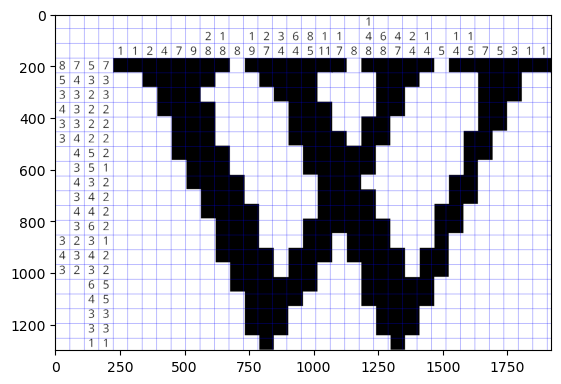

In [246]:
def addAxesFoundToImage(image, parameters):
    (A, alpha, B, beta) = parameters
    imageCopy = image.copy()
    imageCopy = cv2.cvtColor(imageCopy, cv2.COLOR_GRAY2BGR)
    for i in range(-200, 200):
        y = A + alpha * i + alpha//2
        x = B + beta * i + beta//2
        cv2.line(imageCopy, (0, x), (2000, x), (0,0,255))
        cv2.line(imageCopy, (y, 0), (y, 2000), (0,0,255))

    pyplot.imshow(imageCopy)

addAxesFoundToImage(imageCopy, (141, 56, 142, 57))# (49, 21, 67, 21))